## Setup and Data Loading

In [1]:
pip install pyspark


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [33]:
from pyspark.sql import SparkSession

In [34]:
spark = SparkSession.builder.appName("objective_2").getOrCreate()

In [35]:
df = spark.read.csv("india_road_data.csv", inferSchema=True, header=True)

In [36]:
df.columns

['Time',
 'Day_of_week',
 'Age_band_of_driver',
 'Sex_of_driver',
 'Educational_level',
 'Vehicle_driver_relation',
 'Driving_experience',
 'Type_of_vehicle',
 'Owner_of_vehicle',
 'Service_year_of_vehicle',
 'Defect_of_vehicle',
 'Area_accident_occured',
 'Lanes_or_Medians',
 'Road_allignment',
 'Types_of_Junction',
 'Road_surface_type',
 'Road_surface_conditions',
 'Light_conditions',
 'Weather_conditions',
 'Type_of_collision',
 'Number_of_vehicles_involved',
 'Number_of_casualties',
 'Vehicle_movement',
 'Casualty_class',
 'Sex_of_casualty',
 'Age_band_of_casualty',
 'Casualty_severity',
 'Work_of_casuality',
 'Fitness_of_casuality',
 'Pedestrian_movement',
 'Cause_of_accident',
 'Accident_severity']

## Choosing Columns

- **Road_allignment**: Sharp curves, steep inclines, or poorly designed intersections can increase accident risks

- **Road_surface_type**: Different surface types behave differently under various conditions and can affect vehicle control.

- **Road_surface_conditions**:
- **Weather_conditions**:
- **Accident_severity**:
- **Light Conditions**:
- **Type of Collision**:
- **Number of Vehicles Involved**:

In [37]:
selected_columns = ["Road_allignment", "Road_surface_type", "Road_surface_conditions", "Weather_conditions", "Accident_severity", "Light_conditions", "Type_of_collision", "Number_of_vehicles_involved"]
df = df.select(selected_columns)
df.describe().show()
df.show()

+-------+--------------------+-----------------+-----------------------+------------------+-----------------+--------------------+--------------------+---------------------------+
|summary|     Road_allignment|Road_surface_type|Road_surface_conditions|Weather_conditions|Accident_severity|    Light_conditions|   Type_of_collision|Number_of_vehicles_involved|
+-------+--------------------+-----------------+-----------------------+------------------+-----------------+--------------------+--------------------+---------------------------+
|  count|               12174|            12144|                  12316|             12316|            12316|               12316|               12161|                      12316|
|   mean|                NULL|             NULL|                   NULL|              NULL|             NULL|                NULL|                NULL|         2.0406787918155245|
| stddev|                NULL|             NULL|                   NULL|              NULL|         

In [38]:
df = df.na.drop() # drop the Nulls

In [39]:
# remove the 'Others' & 'Unknowns'
df = df.filter(df.Road_surface_type != "Other")
df = df.filter((df.Weather_conditions != "Other") & (df.Weather_conditions != "Unknown"))
df = df.filter(df.Type_of_collision != "Other")

In [40]:
from pyspark.sql.functions import expr
from pyspark.sql.functions import when, col

# Cleaning Accident_severity
df = df.withColumn('Accident_severity', expr("REPLACE(Accident_severity, ' Injury', '')"))

# Cleaning Type_of_collision
replacement_mapping = {
    "Collision with animals": "collision_with_animals",
    "Collision with pedestrians": "collision_with_pedestrians",
    "Collision with roadside objects": "collision_with_roadside_objects",
    "Collision with roadside-parked vehicles": "collision_with_roadside_parked_vehicles",
    "Fall from vehicles": "Fall_from_vehicles",
    "Vehicle with vehicle collision": "vehicle_with_vehicle_collision",
    "With Train": "collision_with_train"
}

for original_value, new_value in replacement_mapping.items():
    df = df.withColumn('Type_of_collision', when(df['Type_of_collision'] == original_value, new_value).otherwise(df['Type_of_collision']))

# Cleaning Road_allignment
replacement_mapping = {
    "Escarpments": "escarpments",
    "Gentle horizontal curve": "gentle_horizontal_curve",
    "Sharp reverse curve": "sharp_reverse_curve",
    "Steep grade downward with mountainous terrain": "steep_grade_downward_with_mountainous_terrain",
    "Steep grade upward with mountainous terrain": "steep_grade_upward_with_mountainous_terrain",
    "Tangent road with flat terrain": "tangent_road_with_flat_terrain",
    "Tangent road with mild grade and flat terrain": "tangent_road_with_mild_grade_and_flat_terrain",
    "Tangent road with mountainous terrain": "tangent_road_with_mountainous_terrain",
    "Tangent road with rolling terrain": "tangent_road_with_rolling_terrain"
}

for original_value, new_value in replacement_mapping.items():
    df = df.withColumn('Road_allignment', when(col('Road_allignment') == original_value, new_value).otherwise(col('Road_allignment')))

# Cleaning Road_surface_type
replacement_mapping = {
    "Asphalt roads": "asphalt_roads",
    "Asphalt roads with some distress": "asphalt_roads_with_some_distress",
    "Earth roads": "earth_roads",
    "Gravel roads": "gravel_roads"
}

for original_value, new_value in replacement_mapping.items():
    df = df.withColumn('Road_surface_type', when(col('Road_surface_type') == original_value, new_value).otherwise(col('Road_surface_type')))

# Cleaning Road_surface_conditions
replacement_mapping = {
    "Flood over 3cm. deep": "flood_3cm_deep",
    "Wet or damp": "wet"
}
for original_value, new_value in replacement_mapping.items():
    df = df.withColumn('Road_surface_conditions', when(col('Road_surface_conditions') == original_value, new_value).otherwise(col('Road_surface_conditions')))


# Cleaning Light_conditions
replacement_mapping = {
    "Darkness - lights lit": "darkness_lights_on",
    "Darkness - lights unlit": "darkness_lights_off",
    "Darkness - no lighting": "darkness_no_lighting",
    "Daylight": "daylight"
}

for original_value, new_value in replacement_mapping.items():
    df = df.withColumn('Light_conditions', when(col('Light_conditions') == original_value, new_value).otherwise(col('Light_conditions')))




In [41]:
df.printSchema()
df.show()

root
 |-- Road_allignment: string (nullable = true)
 |-- Road_surface_type: string (nullable = true)
 |-- Road_surface_conditions: string (nullable = true)
 |-- Weather_conditions: string (nullable = true)
 |-- Accident_severity: string (nullable = true)
 |-- Light_conditions: string (nullable = true)
 |-- Type_of_collision: string (nullable = true)
 |-- Number_of_vehicles_involved: integer (nullable = true)

+--------------------+-----------------+-----------------------+------------------+-----------------+------------------+--------------------+---------------------------+
|     Road_allignment|Road_surface_type|Road_surface_conditions|Weather_conditions|Accident_severity|  Light_conditions|   Type_of_collision|Number_of_vehicles_involved|
+--------------------+-----------------+-----------------------+------------------+-----------------+------------------+--------------------+---------------------------+
|tangent_road_with...|    asphalt_roads|                    Dry|            N

### Converting strings into numerical format (using StringIndexer and OneHotEncoder).

In [3]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

# Indexing all categorical columns
# indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df) for column in selected_columns[:-1]] # Exclude last column 'an interger'
selected_columns_filtered = [column for column in selected_columns]
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df) for column in selected_columns_filtered]

# Indexing the label column (the depandant variable "target")
labelIndexer = StringIndexer(inputCol='Accident_severity', outputCol='label').fit(df)

# Encoding indexed columns
encoders = [OneHotEncoder(inputCol=indexer.getOutputCol(), outputCol=indexer.getOutputCol()+"_vec") for indexer in indexers]

# Assembling vector
assemblerInputs = [encoder.getOutputCol() for encoder in encoders]
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")

# Pipeline
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=indexers + encoders + [assembler, labelIndexer])
pipelineModel = pipeline.fit(df)
df_transformed = pipelineModel.transform(df)



NameError: name 'selected_columns' is not defined

### Split data into training and testing sets
**Seed**: to ensure that whenever you run your code, I get the same training and testing dataset. Without a fixed seed, each run could lead to different training and testing sets.

In [43]:
train, test = df_transformed.randomSplit([0.7, 0.3])
#seed=123

### Model Selection and Training

##### **LogisticRegression**

In [44]:
df.printSchema()

root
 |-- Road_allignment: string (nullable = true)
 |-- Road_surface_type: string (nullable = true)
 |-- Road_surface_conditions: string (nullable = true)
 |-- Weather_conditions: string (nullable = true)
 |-- Accident_severity: string (nullable = true)
 |-- Light_conditions: string (nullable = true)
 |-- Type_of_collision: string (nullable = true)
 |-- Number_of_vehicles_involved: integer (nullable = true)



In [45]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol='features', labelCol='label')

lrModel = lr.fit(train)

### *Model Evaluation in Classification*

- **Accuracy**: The proportion of total correct predictions out of all predictions made.

- **Precision**: The proportion of true positive predictions out of all positive predictions made.

- **Recall**: The proportion of true positive predictions out of all actual positives.

- **F1 Score**: The harmonic mean of precision and recall, providing a balance between the two in cases where they may diverge.

- **Area** Under ROC Curve (AUC-ROC): A performance measurement for classification problems at various threshold settings. ROC is a probability curve and AUC represents the degree or measure of separability.

In [46]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

# Predict on the test set
predictions = lrModel.transform(test)

# Evaluate the model for accuracy
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = accuracy_evaluator.evaluate(predictions)
print("Accuracy = %g" % accuracy)

# Evaluate the model for precision
precision_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
precision = precision_evaluator.evaluate(predictions)
print("Precision = %g" % precision)

# Evaluate the model for recall
recall_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
recall = recall_evaluator.evaluate(predictions)
print("Recall = %g" % recall)

# Evaluate the model for F1 score
f1_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
f1 = f1_evaluator.evaluate(predictions)
print("F1 Score = %g" % f1)


Accuracy = 1
Precision = 1
Recall = 1
F1 Score = 1


## Parameter Tuning and Cross-Validation

In [47]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Expanded parameter grid
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.1, 0.01, 0.001])
             .addGrid(lr.maxIter, [10, 20, 30])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .build())

# Choose the evaluator based on your primary metric or create a composite score
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")  # example using F1

crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)

# Run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit(train)
bestModel = cvModel.bestModel

# Evaluate the best model
bestPredictions = bestModel.transform(test)
bestAccuracy = accuracy_evaluator.evaluate(bestPredictions)
bestPrecision = precision_evaluator.evaluate(bestPredictions)
bestRecall = recall_evaluator.evaluate(bestPredictions)
bestF1 = f1_evaluator.evaluate(bestPredictions)

print(f"Best Model's Accuracy: {bestAccuracy}")
print(f"Best Model's Precision: {bestPrecision}")
print(f"Best Model's Recall: {bestRecall}")
print(f"Best Model's F1 Score: {bestF1}")


Best Model's Accuracy: 0.9997034400948992
Best Model's Precision: 0.9997035448123798
Best Model's Recall: 0.9997034400948992
Best Model's F1 Score: 0.9997019685015938


# Visuals

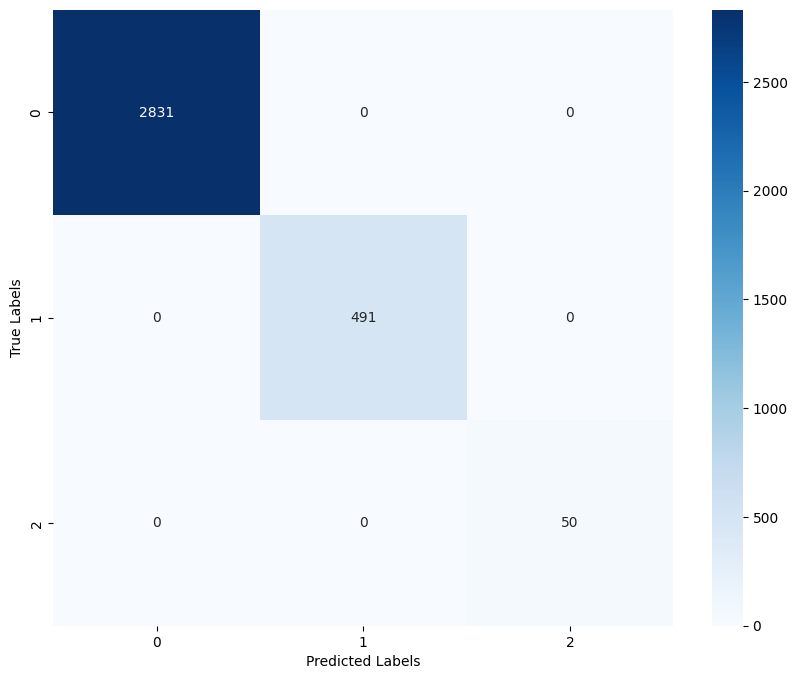

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.mllib.evaluation import MulticlassMetrics

# Convert prediction DataFrame to RDD
predictionAndLabels = predictions.select("prediction", "label").rdd.map(lambda x: (x[0], float(x[1])))

# Instantiate metrics object
metrics = MulticlassMetrics(predictionAndLabels)

# Confusion Matrix
confusion_matrix = metrics.confusionMatrix().toArray()

# Plotting using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, fmt="g", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


# Random Forest

In [49]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
import seaborn as sns


In [50]:
# Random Forest Model
rf = RandomForestClassifier(featuresCol='features', labelCol='label')

# Parameter Grid for Tuning
paramGrid = (ParamGridBuilder()
             .addGrid(rf.numTrees, [10, 20, 50])
             .addGrid(rf.maxDepth, [5, 10, 15])
             .addGrid(rf.maxBins, [32, 64, 128])
             .build())

# Cross Validator
crossval_rf = CrossValidator(estimator=rf,
                             estimatorParamMaps=paramGrid,
                             evaluator=MulticlassClassificationEvaluator(),
                             numFolds=5)


In [51]:

# Train model using CrossValidator
cvModel_rf = crossval_rf.fit(train)



In [52]:
# Best Model
bestModel_rf = cvModel_rf.bestModel

# Make predictions
predictions_rf = bestModel_rf.transform(test)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
accuracy_rf = evaluator.evaluate(predictions_rf, {evaluator.metricName: "accuracy"})
precision_rf = evaluator.evaluate(predictions_rf, {evaluator.metricName: "weightedPrecision"})
recall_rf = evaluator.evaluate(predictions_rf, {evaluator.metricName: "weightedRecall"})
f1_rf = evaluator.evaluate(predictions_rf, {evaluator.metricName: "f1"})

print(f"Random Forest Model - Accuracy: {accuracy_rf}")
print(f"Random Forest Model - Precision: {precision_rf}")
print(f"Random Forest Model - Recall: {recall_rf}")
print(f"Random Forest Model - F1 Score: {f1_rf}")

Random Forest Model - Accuracy: 1.0
Random Forest Model - Precision: 1.0
Random Forest Model - Recall: 1.0
Random Forest Model - F1 Score: 1.0


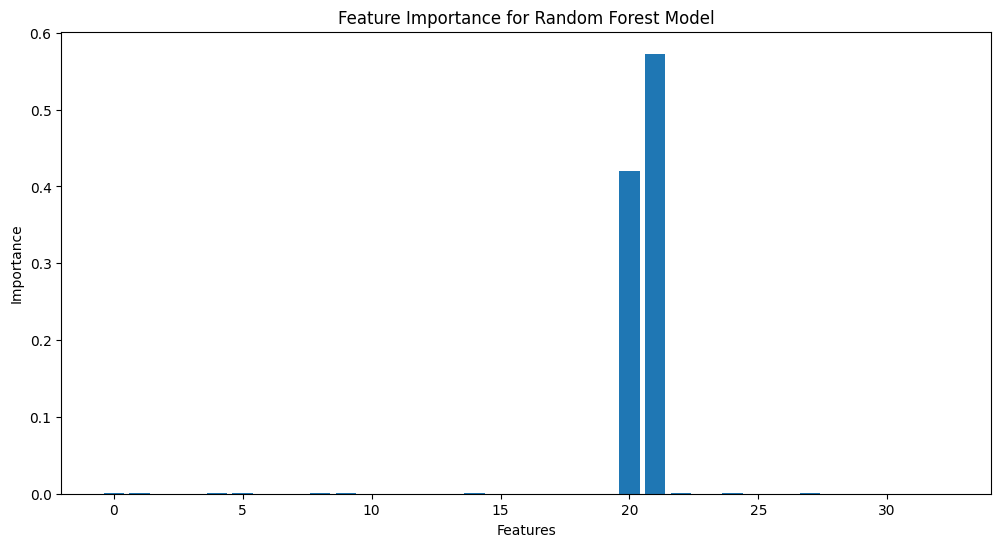

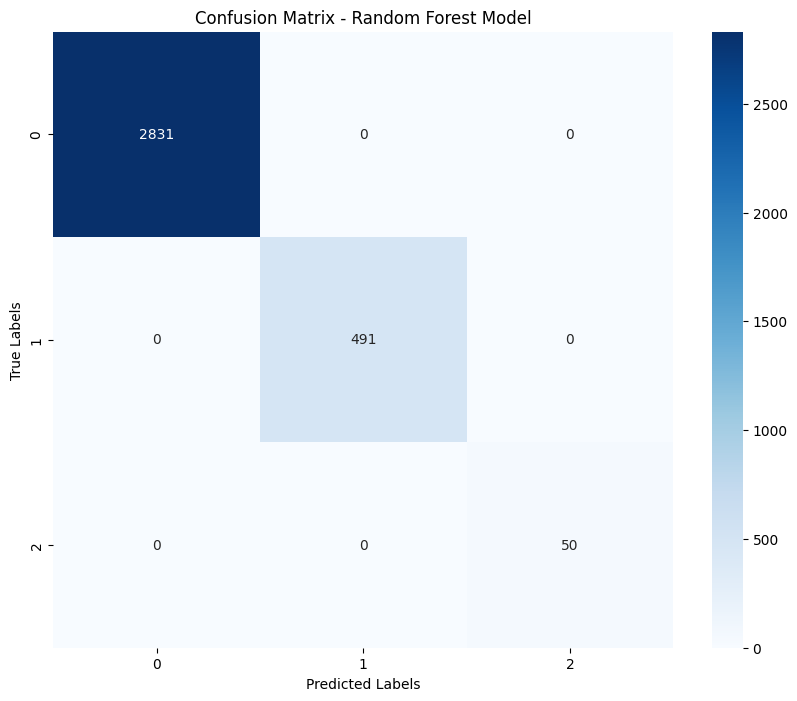

In [53]:
# Feature Importance
feature_importance = bestModel_rf.featureImportances.toArray()
plt.figure(figsize=(12, 6))
plt.bar(range(len(feature_importance)), feature_importance)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance for Random Forest Model')
plt.show()

# Confusion Matrix
from pyspark.mllib.evaluation import MulticlassMetrics

# Convert to RDD
predictionsAndLabels_rf = predictions_rf.select("prediction", "label").rdd.map(lambda x: (x[0], float(x[1])))

# Instantiate metrics object
metrics_rf = MulticlassMetrics(predictionsAndLabels_rf)

# Confusion Matrix
confusion_matrix_rf = metrics_rf.confusionMatrix().toArray()

# Plotting
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix_rf, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Random Forest Model')
plt.show()
